In [2]:
import numpy as np
from scipy.stats import bernoulli
import random
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"]=20,20


In [3]:
# Takes a list of n bits and produces degree*n bits, `degree' bits produced by broadcast process from each input bit 
def expandArrayFast(L,degree,eps):
    A = np.zeros((len(L),degree))
    for j in range(0,degree):
        biased_bits = bernoulli.rvs(0.5+eps,size=len(L))
        A[:,j] = biased_bits * L + (1-biased_bits)*(1-L)
    return A.flatten()

# Applies expandArrayFast recursively depth times, takes a list L of n bits and produces all leaves of depth trees 
# starting from each bit separately.
def expandTreeFast(L,depth,degree,eps):
    prevL = L
    for i in range(0,depth):
        currentL = expandArrayFast(prevL,degree,eps)
        prevL    = currentL
    return prevL

# Takes a list L of n*degree numbers, produces n numbers by applying local Bayes 
def contractArrayFast(L,degree,eps):
    M = np.reshape(L,(-1,degree))
    #weights1 = [(0.5+eps)*a + (0.5-eps)*(1 - a) for a in P]
    weights1 = (0.5 - eps) + 2*eps*M
    #weights0 = [(0.5-eps)*a + (0.5+eps)*(1 - a) for a in P]
    weights2 = 1.0- weights1    
    #w1 = np.prod(weights1)
    w1 = np.prod(weights1,axis=1)
    #w0 = np.prod(weights0)
    w0 = np.prod(weights2,axis=1)
    #z = w1 + w0
    z = w1 + w0
    return w1/z

# Applies contract Array recursively
def contractTreeFast(L,depth,degree,eps):
    prevL = L
    for i in range(0,depth):
        currentL = contractArrayFast(prevL,degree,eps)
        prevL    = currentL
    return prevL

# Compute empirical distribution
def get_empirical_dist(numTrials,depth,degree,eps):
    blockSize = 50
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        leafSigns = expandTreeFast(rootList,depth,degree,eps)
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafSigns,depth,degree,eps)))
    return emp_dist

# Compute an empirical sample of E_p[x_root] for an Ising model p on a tree of given depth and arity, where p
# is given by Hamiltonian 
# H(x) = log([1+2eps]/[1-2eps]) \sum_{i~j} x_i x_j + log([1+sigma_i m_i]/[1-sigma_i m_i]) \sum_{leaves i} x_i
#
# Here, sigma_i \in {-1,1} is a random draw from either the broadcast process on the tree, or is i.i.d. {-1,1} (see below)
# and m_i are message strenghts drawn randomly from leaf_message_strengths.
# Optional parameters:
#     messageSignRandomness: set either to "broadcast" or "random"; the latter makes the sigma_i's into i.i.d. bits
#     fixMessageStrengths: rather than draw fresh message strengths from leaf_message_strengths for each trial, fix a single draw from leaf_message_strenghts and randomize everything else
#     fixMessageSigns: same as above, but for the leaf bit randomness
#     blockSize: how many trials to run at once (should not need to change from default value)
def get_root_dist(leaf_message_strengths,numTrials,depth,degree,eps,messageSignRandomness="broadcast",fixMessageStrengths=False,fixMessageSigns=False,blockSize=50):
    emp_dist = np.array([])
    
    # do an initial sample of all the randomness
    rootList = np.ones(blockSize)
    leafBits = None
    if messageSignRandomness=="broadcast":
        leafBits = expandTreeFast(rootList,depth,degree,eps)
    elif messageSignRandomness=="independent":
        leafBits = np.random.choice([0,1],(blockSize,(degree**depth)))
    else:
        print("Error: illegal argument value messageSignRandomness=" + messageSignRandomness)
    
    leafBias = np.random.choice(leaf_message_strengths,np.shape(leafBits))
    
    # run the random trials, resampling whatever randomness we are supposed to
    for i in range(0,numTrials,blockSize):
        
        if not fixMessageSigns:
            if messageSignRandomness=="broadcast":
                rootList = np.ones(blockSize)
                leafBits = expandTreeFast(rootList,depth,degree,eps)
            elif messageSignRandomness=="independent":
                leafBits = np.random.choice([0,1],(blockSize,(degree**depth)))            
        
        if not fixMessageStrengths:
            leafBias = np.random.choice(leaf_message_strengths,np.shape(leafBits))
            
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages,depth,degree,eps)))
        
    return emp_dist
    

# testing fixed-point ness. OBSOLETE, use get_root_dist instead
def test_Fixed_Point(old_emp_dist,numTrials,depth,degree,eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(old_emp_dist,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,eps)))
    return new_emp_dist

# testing universality. OBSOLETE, use get_root_dist instead. 
def test_Universality(marginals,numTrials,depth,degree,eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(marginals,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,eps)))
    return new_emp_dist

# Fix the marginals, but vary the broadcast to plot the histogram. OBSOLETE, use get_root_dist instead
def test_Fix_Marginals(marginals,numTrials,depth,degree,eps):
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = (expandTreeFast(rootList,depth,degree,eps)).reshape((blockSize,-1))
        #   Copying marginals again and again
        leafBias = marginals
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages.flatten(),depth,degree,eps)))
    return emp_dist

# if the broadcast process is fixed but we vary the leaf messages in a mean-zero way, what distribution does it generate?
# OBSOLETE, use get_root_dist instead
def test_Fixed_Broadcast_Variable_Marginals(marginals,numTrials,depth,degree,eps):
    emp_dist = np.array([])
    #broadcast process to create leaf bits
    rootList = np.ones(blockSize)
    leafBits = expandTreeFast(rootList,depth,degree,eps)
    for i in range(0,numTrials,blockSize):
        #   randomize the marginals
        leafBias = np.random.choice(marginals,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages.flatten(),depth,degree,eps)))
    return emp_dist

# Fix the marginals, but vary leaves u.a.r. to plot the histogram
# OBSOLETE, use get_root_dist instead
def test_Fix_Marginals_Random_Leaves(marginals,numTrials,depth,degree,eps):
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via i.i.d. from {0,1}
        leafBits = (np.random.choice([0,1], (blockSize,(degree**depth))))
        #   Copying marginals again and again
        leafBias = (np.random.choice(marginals,len(leafBits)*blockSize)).reshape(blockSize,(degree**depth))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages.flatten(),depth,degree,eps)))
    return emp_dist
    

# TODO: reimplement using get_root_dist
def mymain():
    
#    print("Computing Emprical Distribution:")
#    theta = get_empirical_dist(numTrials,depth,degree,eps)
#    mean_theta = np.mean(theta)
#    sigma_theta = np.var(theta)
#    print("Empirical Distribution Mean:",np.mean(theta))
#    print("Empirical Distribution Variance:",np.sqrt(np.var(theta)))
#    plt.hist(theta,50)
    
#    print("Testing Fixed-pointness:")
#    new_theta = test_Fixed_Point(theta,numTrials,depth,degree,eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

#    print("Testing Universality with Gaussian inputs:")
#    marginals = np.random.normal(mean_theta,sigma_theta,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

#    print("Testing Chaos:")
    #Changing mean and variance arbitrarily
#    marginals = np.random.normal(mean_theta,sigma_theta/100.0,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)


    print("Testing One Parameter Family")
    mu = 0.8
    mu_prime = 0.6
    sigma = 0.1
    sigma_prime = 0.2
    # Using random gaussian marginals with mean mu, variance sigma
    # gaussian_marginals = np.random.normal(mu,sigma,numTrials)
    # gaussian_theta = test_Universality(gaussian_marginals,numTrials,depth,degree,eps)
    # print("Output Mean with Gaussian marginals:",np.mean(gaussian_theta))
    # print("Output variance with Gaussian marginales",np.sqrt(np.var(gaussian_theta)))
    # plt.hist(gaussian_theta,50,alpha=0.6)
    
    gaussian_marginals_ms = np.random.normal(mu,sigma,numTrials)
    gaussian_theta_ms = test_Fix_Marginals_Random_Leaves(gaussian_marginals_ms,numTrials,depth,degree,eps)
    
    gaussian_marginals_mps = np.random.normal(mu_prime,sigma,numTrials)
    gaussian_theta_mps = test_Fix_Marginals_Random_Leaves(gaussian_marginals_mps,numTrials,depth,degree,eps)

    gaussian_marginals_msp = np.random.normal(mu,sigma_prime,numTrials)
    gaussian_theta_msp = test_Fix_Marginals_Random_Leaves(gaussian_marginals_msp,numTrials,depth,degree,eps)

    gaussian_marginals_mpsp = np.random.normal(mu_prime,sigma_prime,numTrials)
    gaussian_theta_mpsp = test_Fix_Marginals_Random_Leaves(gaussian_marginals_mpsp,numTrials,depth,degree,eps)

    plt.hist(gaussian_theta_ms,50,alpha=0.6,label=("mu=" + str(mu) + ", sigma="+str(sigma)))
    plt.hist(gaussian_theta_mps,50,alpha=0.6,label=("mu=" + str(mu_prime) + ", sigma="+str(sigma)))
    plt.hist(gaussian_theta_msp,50,alpha=0.6,label=("mu=" + str(mu) + ", sigma="+str(sigma_prime)))
    plt.hist(gaussian_theta_mpsp,50,alpha=0.6,label=("mu=" + str(mu_prime) + ", sigma="+str(sigma_prime)))



    
    
    plt.xlim(0,1)
    plt.legend()
    
    plt.show()
    
    '''
    # Using fixed gaussian marginals with mean mu_prime, variance sigma
    fixed_gaussian_marginals = np.random.normal(mu_prime,sigma,degree**depth)
    gaussian_theta = test_Fix_Marginals_Random_Leaves(fixed_gaussian_marginals,numTrials,depth,degree,eps)
    print("Output Mean with Gaussian marginals:",np.mean(gaussian_theta))
    print("Output variance with Gaussian marginales",np.sqrt(np.var(gaussian_theta)))
    plt.hist(gaussian_theta,50,alpha=0.6,label=("mu=" + str(mu_prime) + ", sigma="+str(sigma)))

    # Fixed marginals by Gaussian mean mu and variance sigma
    fixed_gaussian_marginals = np.random.normal(mu,sigma,degree**depth)
    fix_gaussian_theta = test_Fix_Marginals_Random_Leaves(fixed_gaussian_marginals,numTrials,depth,degree,eps)
    print("Length of fix_theta",len(fix_gaussian_theta))
    # print("Output Mean with Fixed Gaussian Marginals:",np.mean(fix_gaussian_theta))
    # print("Output Variance with Fixed Gaussian Marginals:",np.sqrt(np.var(fix_gaussian_theta)))
    plt.hist(fix_gaussian_theta,50,alpha=0.6,label=("mu=" + str(mu) + ", sigma="+str(sigma)))
       
    # Fixed random marginals with value mu, variance sigma_prime
    fixed_marginals = np.random.normal(mu,sigma_prime,degree**depth)
    for i in range(len(fixed_marginals)):
        fixed_marginals[i] = min(1.0, fixed_marginals[i])
        fixed_marginals[i] = max(0.0, fixed_marginals[i])
    fix_theta = test_Fix_Marginals_Random_Leaves(fixed_marginals,numTrials,depth,degree,eps)
    print("Length of fix_theta",len(fix_theta))
    print("Output Mean with Fixed Marginals:",np.mean(fix_theta))
    print("Output Variance with Fixed Marginals:",np.sqrt(np.var(fix_theta)))
    plt.hist(fix_theta,50,alpha=0.6,label=("mu=" + str(mu) + ", sigma="+str(sigma_prime)))
    '''
    
 
blockSize = 50
numTrials = 20000
depth     = 8
degree    = 3
eps       = 0.30
    

In [4]:
def getDiscreteLeafBiases(mu,tau,numTrials):
    return np.random.choice([mu + tau, mu - tau], numTrials)

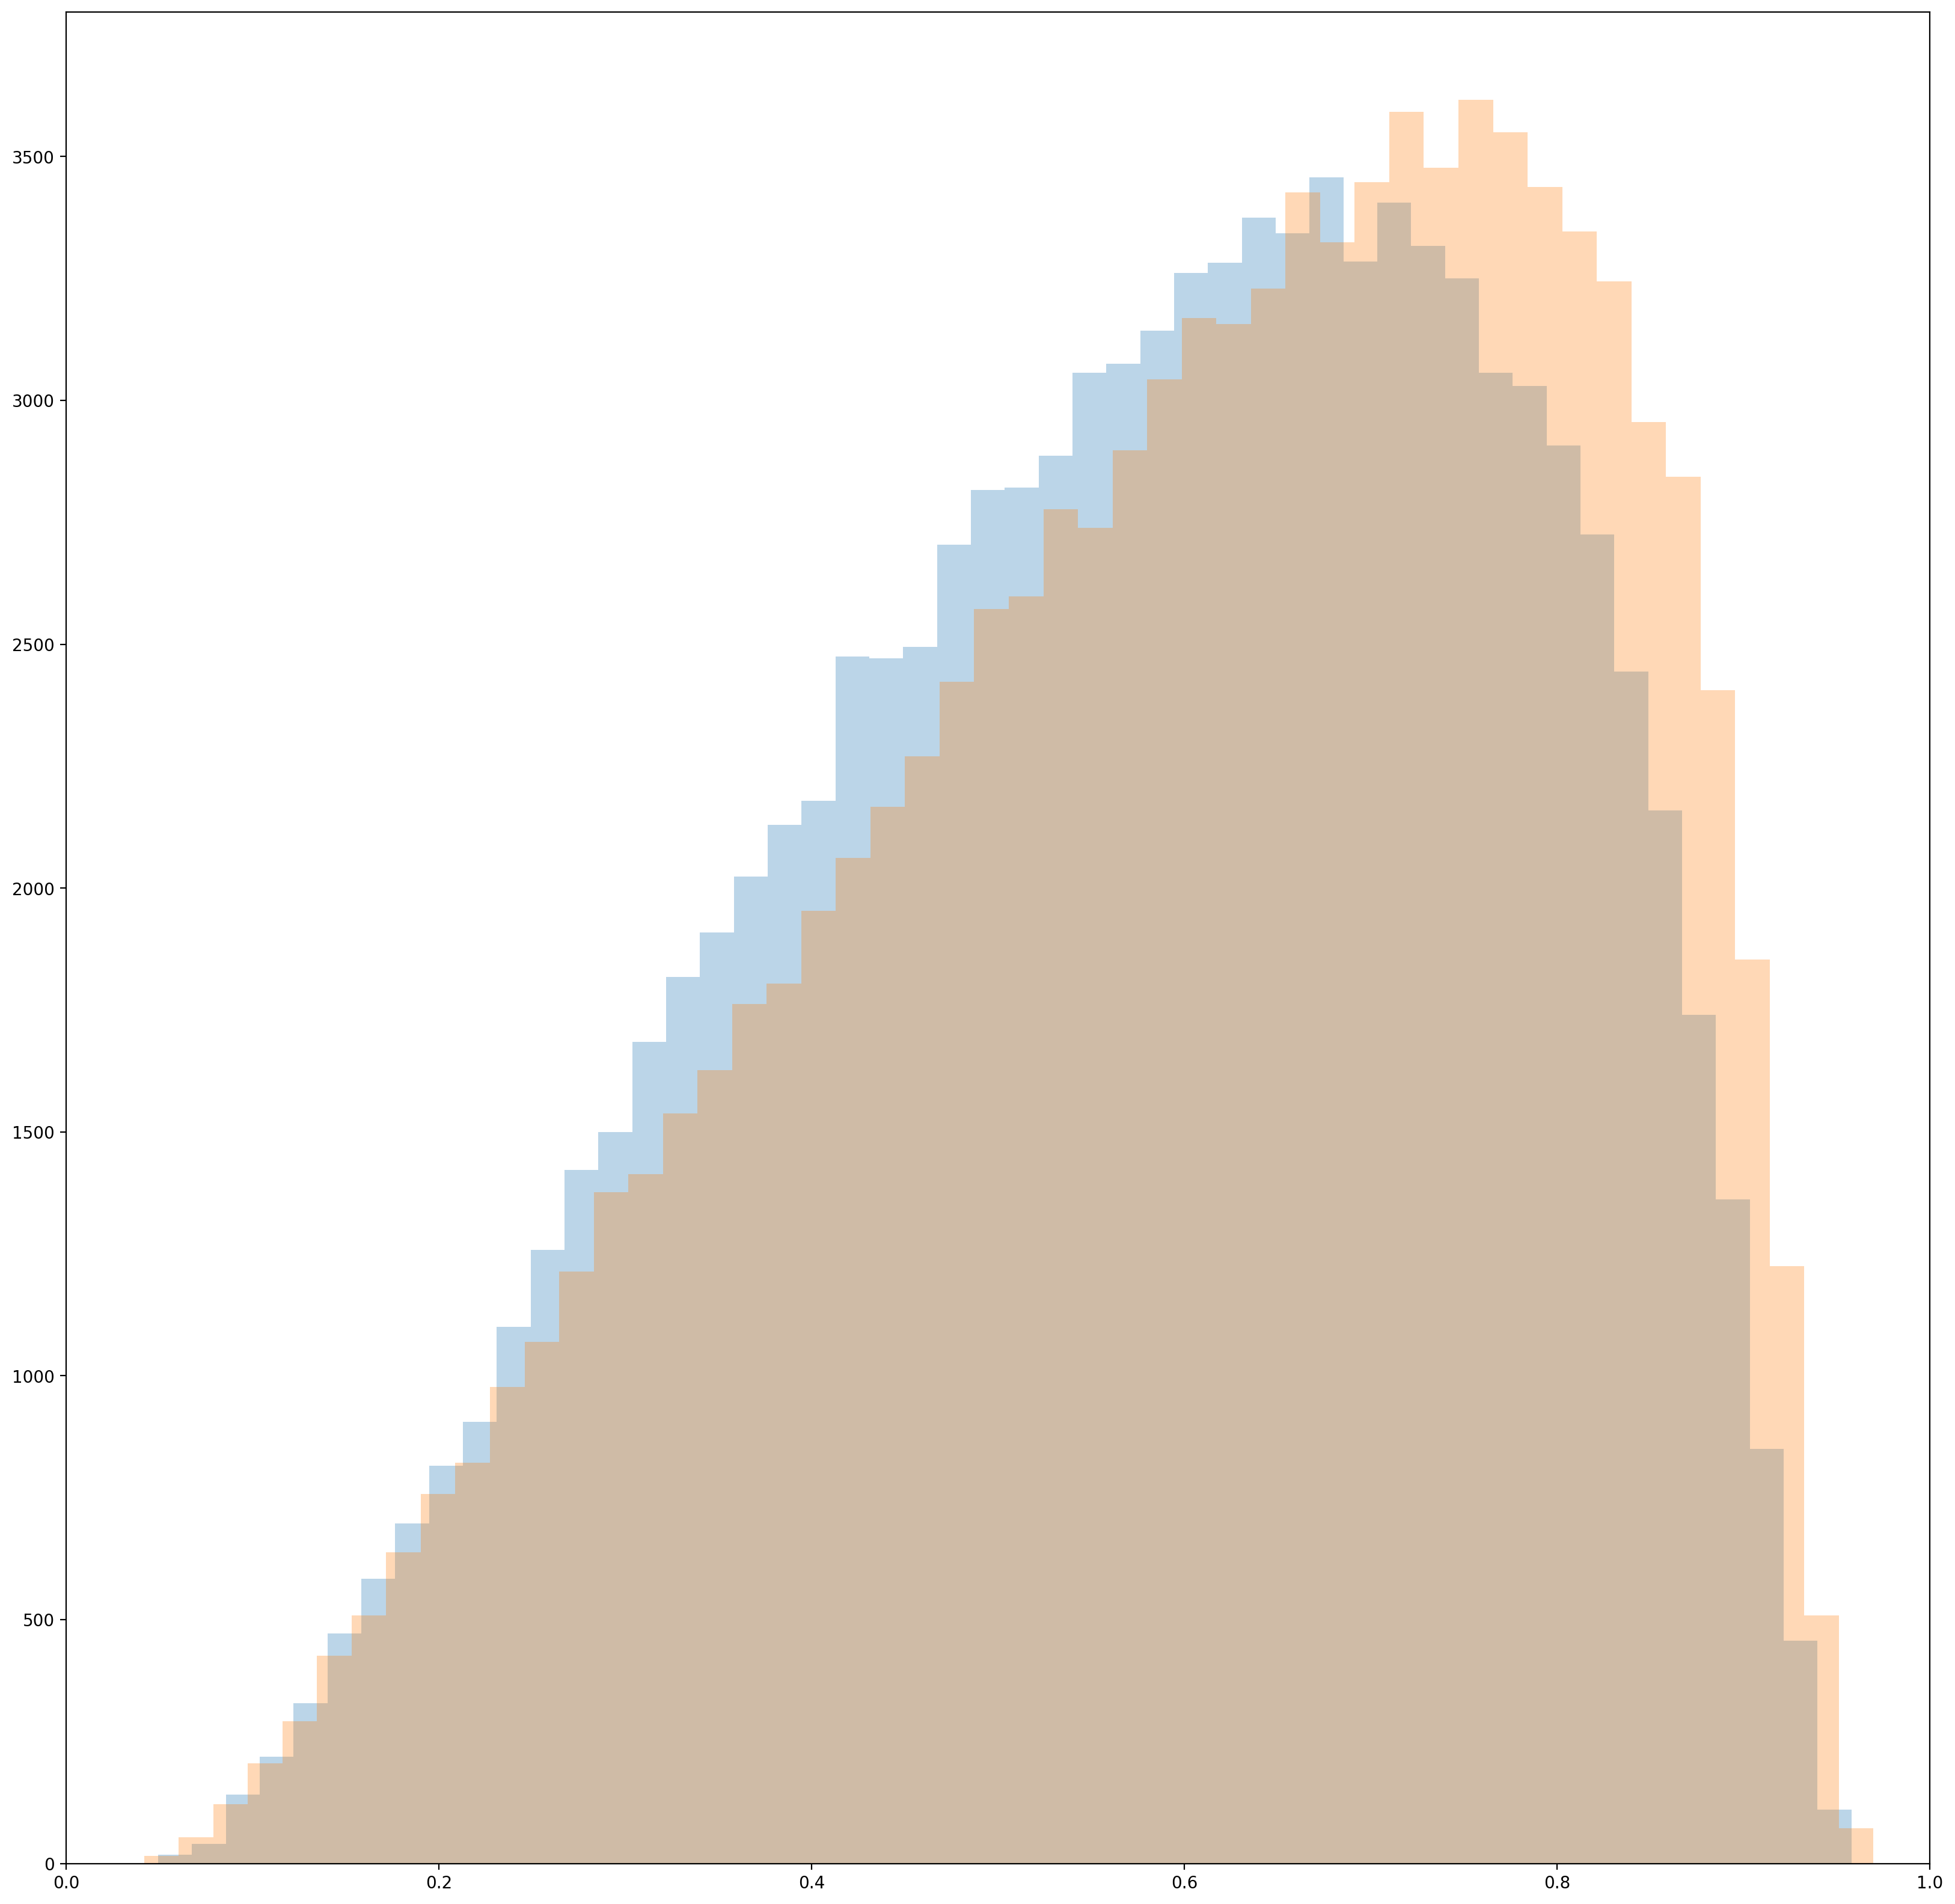

In [5]:
mu = 0.65
mu_prime = 0.51
sigma = 0.32
sigma_prime = 0.0
numTrials = 100000
eps = 0.30
depth = 8
degree = 3

theta = get_root_dist(getDiscreteLeafBiases(mu,sigma,numTrials), numTrials, depth, degree, eps, messageSignRandomness="broadcast")
plt.hist(theta, 50, alpha=0.3,label="mu="+str(mu)+" sigma="+str(sigma))

# theta2 = get_root_dist(getDiscreteLeafBiases(mu_prime,sigma,numTrials), numTrials, depth, degree, eps, messageSignRandomness="broadcast")
# plt.hist(theta2, 50, alpha=0.3,label="mu="+str(mu_prime)+" sigma="+str(sigma))

theta3 = get_root_dist(getDiscreteLeafBiases(mu,sigma_prime,numTrials), numTrials, depth, degree, eps, messageSignRandomness="broadcast")
plt.hist(theta3, 50, alpha=0.3,label="mu="+str(mu)+" sigma="+str(sigma_prime))

# theta4 = get_root_dist(getDiscreteLeafBiases(mu_prime,sigma_prime,numTrials), numTrials,depth,degree,eps,messageSignRandomness="broadcast")
# plt.hist(theta4, 50, alpha=0.3,label="mu="+str(mu_prime)+" sigma="+str(sigma_prime))


plt.xlim(0,1)

plt.show()

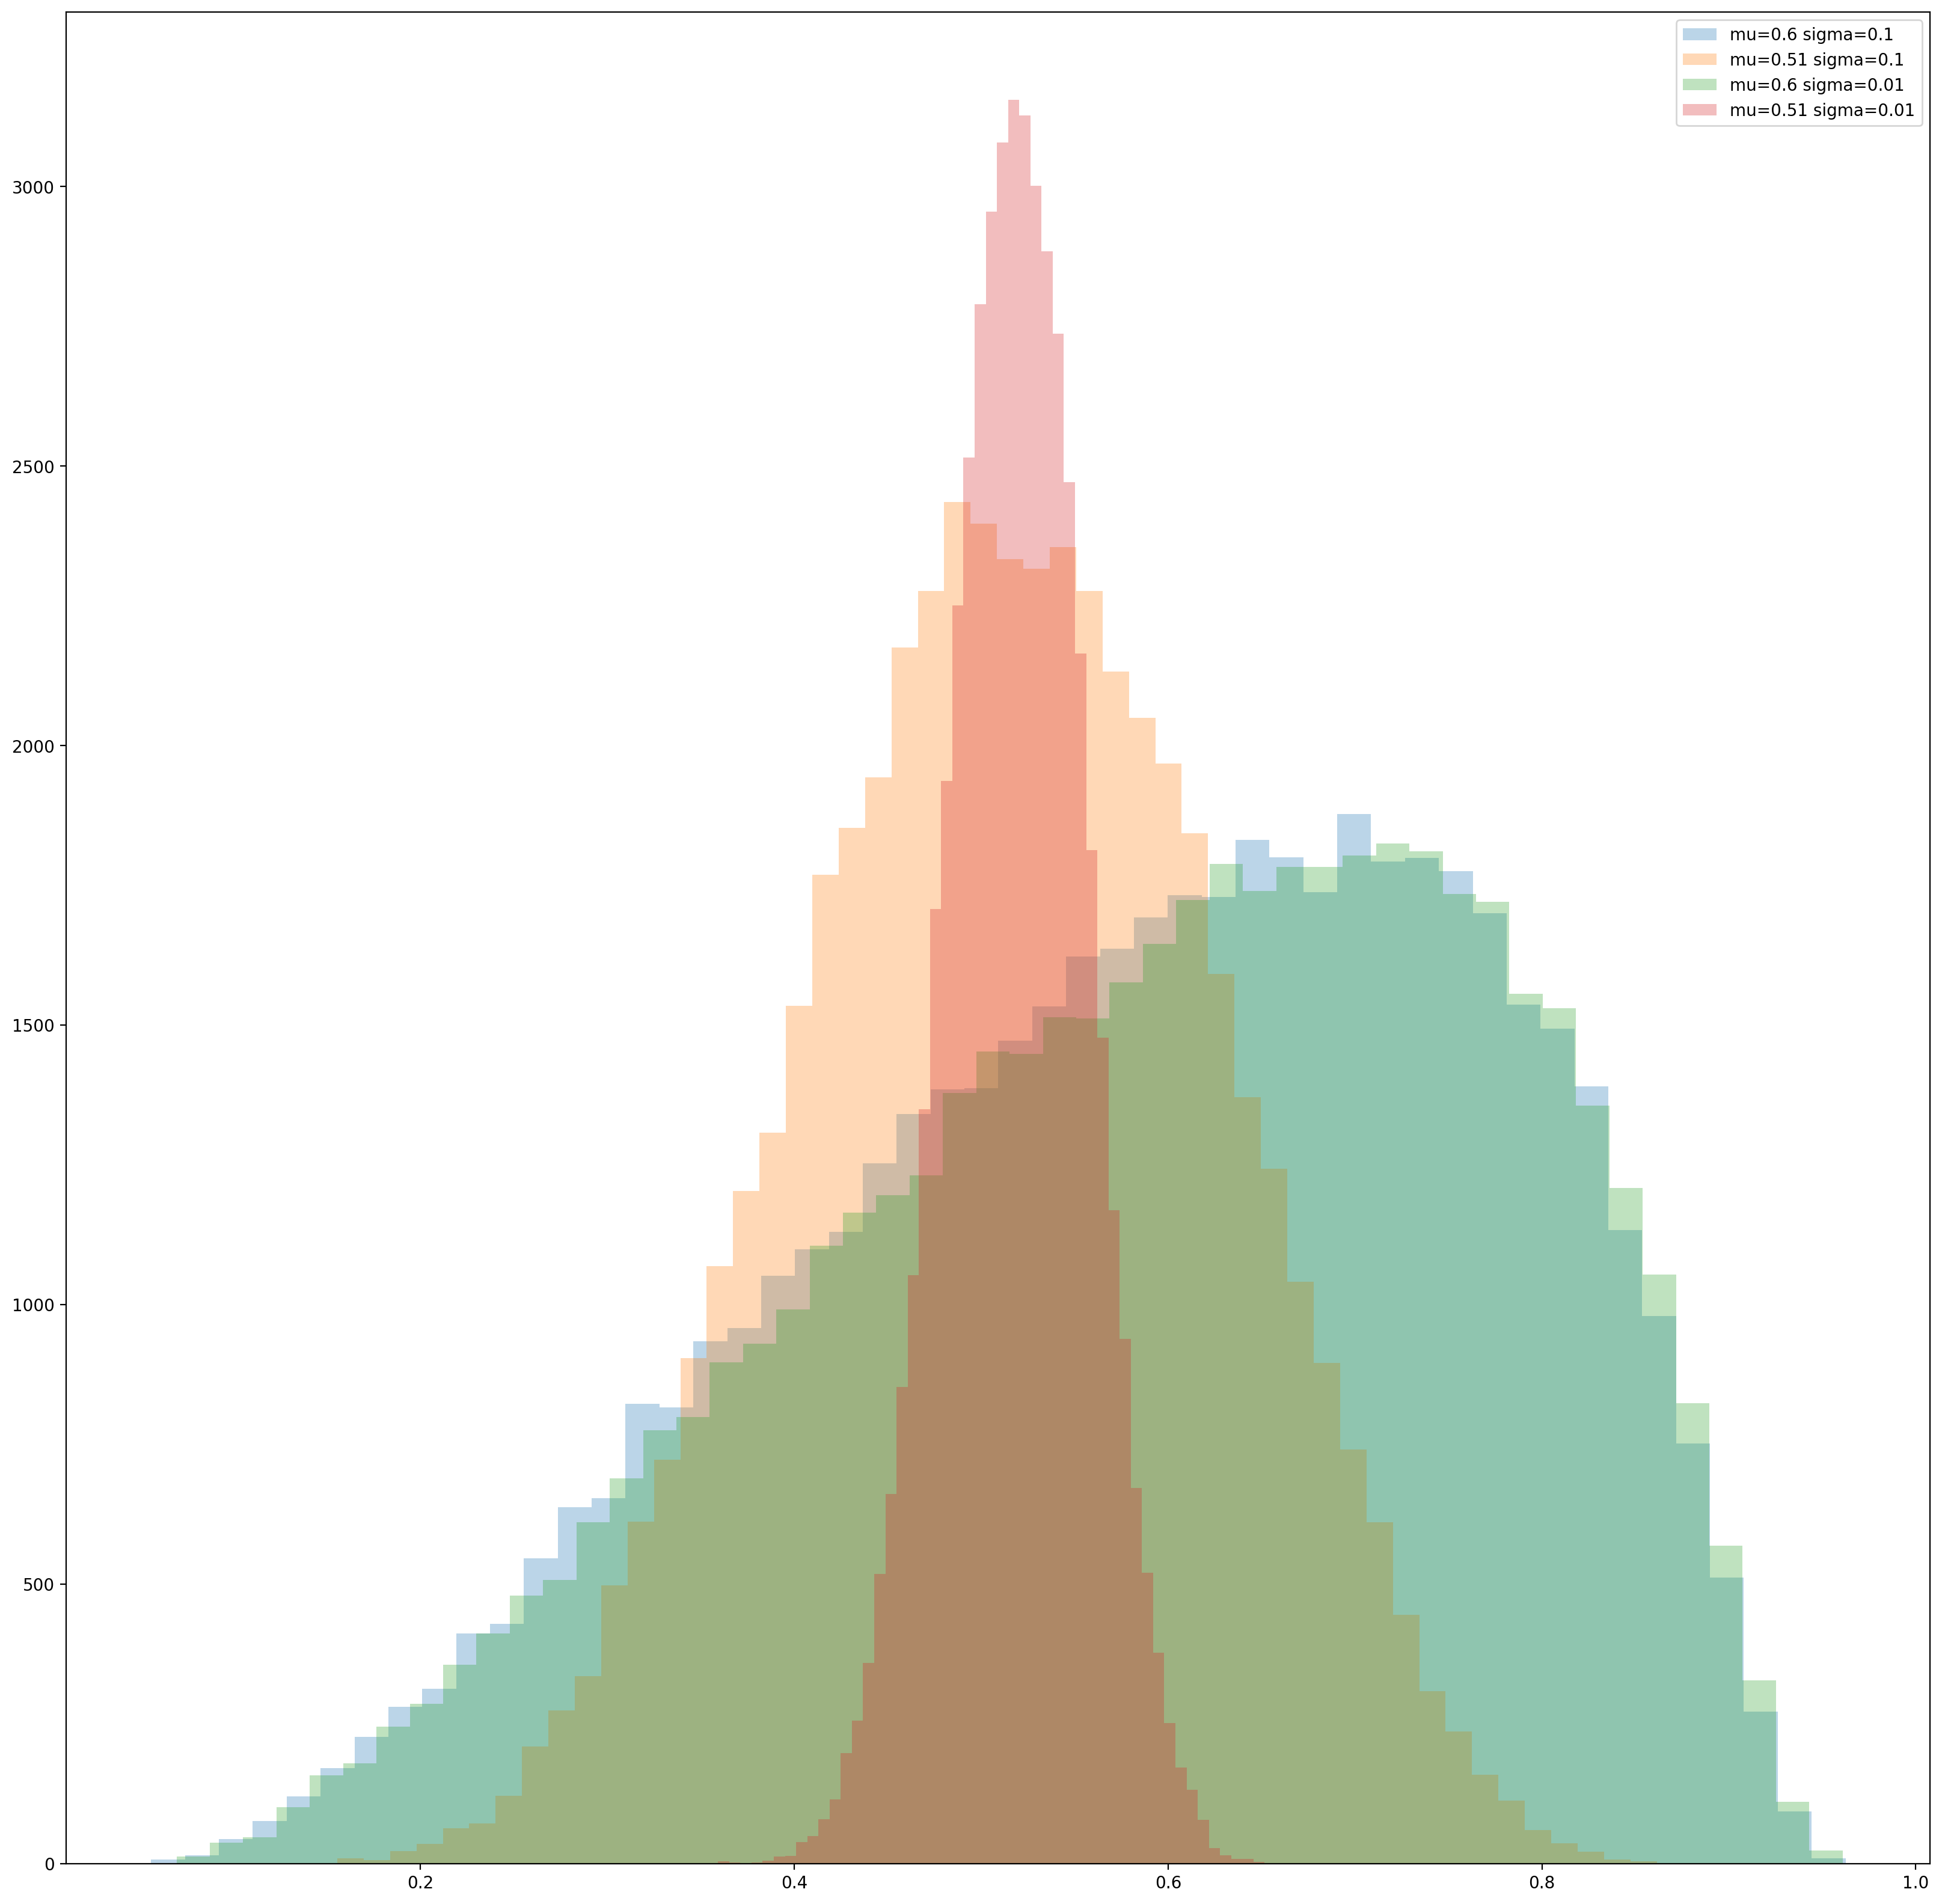

In [20]:
plt.hist(theta, 50, alpha=0.3,label="mu="+str(mu)+" sigma="+str(sigma))
plt.hist(theta2, 50, alpha=0.3,label="mu="+str(mu_prime)+" sigma="+str(sigma))
plt.hist(theta3, 50, alpha=0.3,label="mu="+str(mu)+" sigma="+str(sigma_prime))
plt.hist(theta4, 50, alpha=0.3,label="mu="+str(mu_prime)+" sigma="+str(sigma_prime))


plt.legend()
plt.show()

## Plotting  input vs output mean
The above suggests that fixed $\mu$ captures distributions with mean $\mu$. What is the output mean as a function of the input mean $\mu$? Let's plot this function

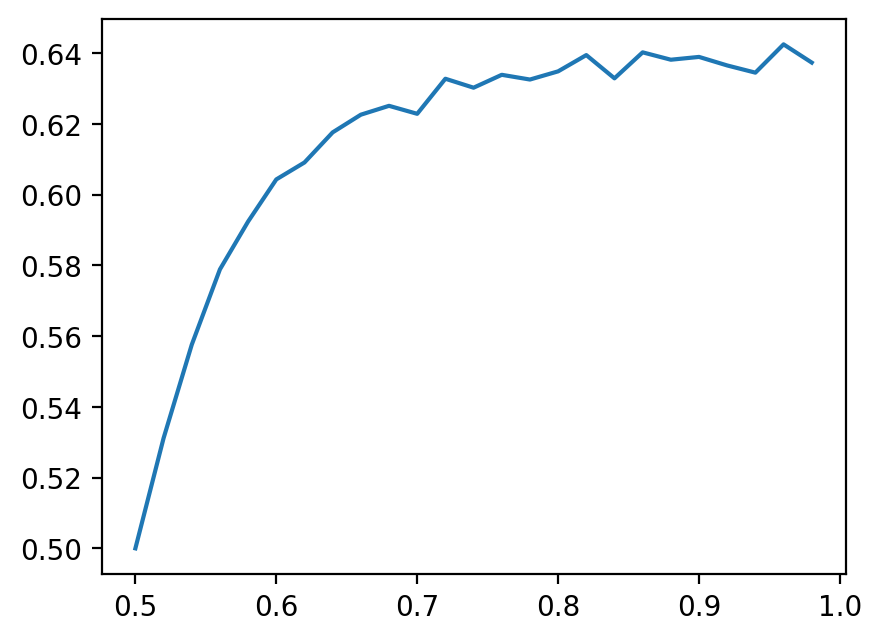

In [28]:
in_mus = [i / 50.0 + 0.5 for i in range(25)]
out_mus = []

depth     = 6
degree    = 3
eps       = 0.3
blockSize = 100
numTrials = 10000

for mu in in_mus:
    fixed_marginals = np.full(degree**depth, mu)
    fix_theta = test_Fix_Marginals(fixed_marginals,numTrials,depth,degree,eps)
    out_mus.append(np.mean(fix_theta))
    
plt.plot(in_mus,out_mus)

## Fix the output of the broadcast process, just vary the marginals -- what distribution do we get?

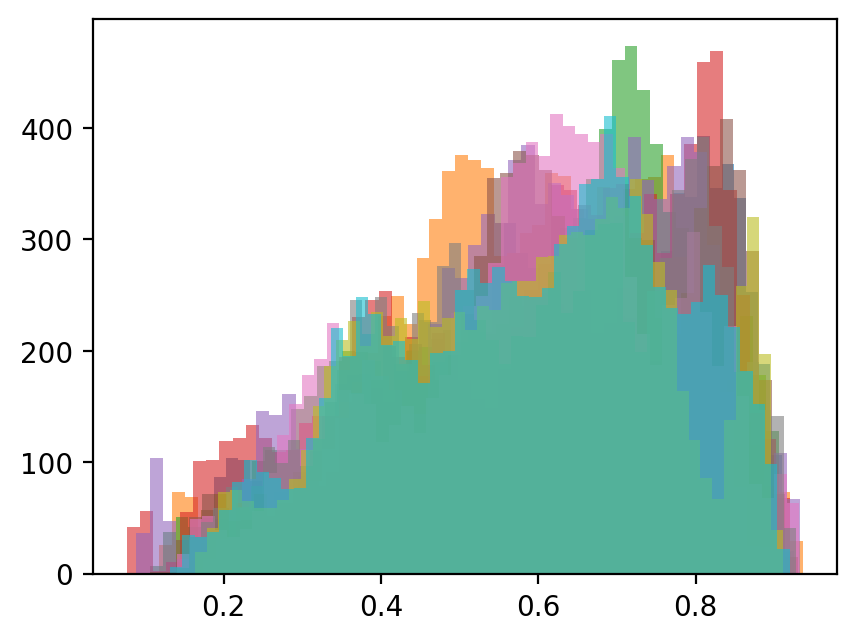

In [6]:
mu = 0.61
sigma = 0.045
numTrials = 10000

# Using random gaussian marginals with mean mu, variance sigma
gaussian_marginals = np.random.normal(mu,sigma,numTrials)
for i in range(10):
    theta = test_Fixed_Broadcast_Variable_Marginals(gaussian_marginals,numTrials,depth,degree,eps)
    plt.hist(theta,50,alpha=0.6)

## Same as above, fixed broadcast but now randomize over leaf messages from the fixed-point dist. Should get the universal distribution...

(array([   9.,   21.,   70.,  117.,  216.,  365.,  477.,  643.,  780.,
         987., 1143., 1266., 1422., 1468., 1704., 1724., 1872., 2003.,
        2044., 2244., 2251., 2314., 2430., 2517., 2568., 2672., 2716.,
        2761., 2847., 2941., 3047., 3112., 3252., 3250., 3472., 3563.,
        3486., 3517., 3519., 3584., 3338., 3166., 3049., 2657., 2306.,
        1951., 1466., 1031.,  553.,   89.]),
 array([0.07666747, 0.09434544, 0.11202341, 0.12970138, 0.14737935,
        0.16505731, 0.18273528, 0.20041325, 0.21809122, 0.23576919,
        0.25344716, 0.27112513, 0.28880309, 0.30648106, 0.32415903,
        0.341837  , 0.35951497, 0.37719294, 0.3948709 , 0.41254887,
        0.43022684, 0.44790481, 0.46558278, 0.48326075, 0.50093871,
        0.51861668, 0.53629465, 0.55397262, 0.57165059, 0.58932856,
        0.60700653, 0.62468449, 0.64236246, 0.66004043, 0.6777184 ,
        0.69539637, 0.71307434, 0.7307523 , 0.74843027, 0.76610824,
        0.78378621, 0.80146418, 0.81914215, 0.83682011, 

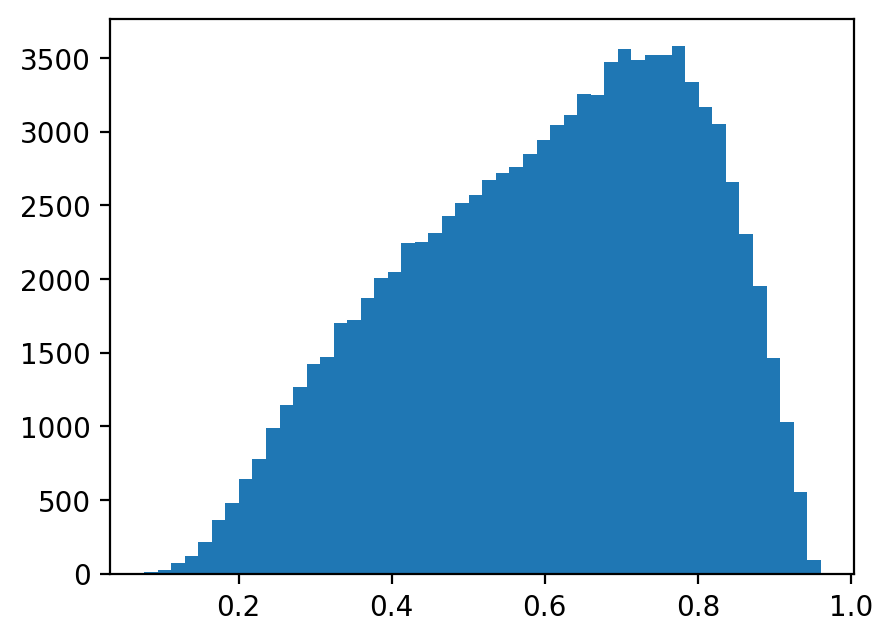

In [10]:
theta_emp = get_empirical_dist(numTrials,depth,degree,eps)
theta = test_Fixed_Broadcast_Variable_Marginals(theta_emp,numTrials,depth,degree,eps)
plt.hist(theta,50)

## Testing

(array([  1.,  10.,   7.,  24.,  26.,  56.,  58.,  94., 130., 100., 145.,
        170., 200., 213., 273., 279., 309., 355., 345., 404., 414., 422.,
        420., 458., 436., 467., 422., 394., 435., 334., 348., 392., 321.,
        278., 228., 200., 166., 161., 122., 107.,  72.,  66.,  50.,  28.,
         26.,  14.,   7.,   8.,   3.,   2.]),
 array([0.15817266, 0.17227937, 0.18638609, 0.2004928 , 0.21459952,
        0.22870623, 0.24281294, 0.25691966, 0.27102637, 0.28513309,
        0.2992398 , 0.31334652, 0.32745323, 0.34155994, 0.35566666,
        0.36977337, 0.38388009, 0.3979868 , 0.41209352, 0.42620023,
        0.44030694, 0.45441366, 0.46852037, 0.48262709, 0.4967338 ,
        0.51084051, 0.52494723, 0.53905394, 0.55316066, 0.56726737,
        0.58137409, 0.5954808 , 0.60958751, 0.62369423, 0.63780094,
        0.65190766, 0.66601437, 0.68012108, 0.6942278 , 0.70833451,
        0.72244123, 0.73654794, 0.75065466, 0.76476137, 0.77886808,
        0.7929748 , 0.80708151, 0.82118823, 0.

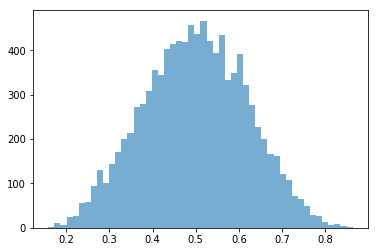

In [14]:
mu = 0.61
sigma = 0.045
numTrials = 10000
theta = get_root_dist(np.random.normal(mu,sigma,numTrials), numTrials, depth, degree, eps, messageSignRandomness="independent")
plt.hist(theta, 50, alpha=0.6)

In [3]:
emp_dist = get_empirical_dist(10000,depth,degree,eps)

In [4]:
np.mean(emp_dist)

0.6220869108526862